Apresentar a ideia:

- Comparar de uma maneira breve sobre o CCSSE e ALGREC, falando da capacidade de encontrar contrafactual similar ao ALGREC e, alem disso, também encontra outra opçoes que envolvem varios atributos

- a outra ideia do que fazer é comparar o comportamente do CCSSE em relaçao ao tamanho da base. O comportamento dos contrafactuais encontrados é interessante conforme vc muda a quantidade de atributos

In [1]:
!pip install lingam

In [1]:
#German
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split

from csse import CSSE
from prepare_dataset import *

import pickle

import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

from tqdm import tqdm
import random as rnd

from IPython.display import display

import warnings

warnings.filterwarnings('ignore')

In [2]:
map_columns = {
    'Unnamed: 0': 'index',
    'x0': 'Sex',
    'x1': 'Age',
    'x2': 'Credit',
    'x3': 'LoanDuration',
    'x4': 'CheckingAccountBalance',
    'x5':'SavingsAccountBalance',
    'x6':'HousingStatus'
}

In [3]:
# Read Dataset German
x_train = pd.read_csv("data/algrec_german/X_train.csv").rename(columns=map_columns)
x_test = pd.read_csv("data/algrec_german/X_test.csv").rename(columns=map_columns)
y_train = pd.read_csv("data/algrec_german/y_train.csv").rename(columns={'Unnamed: 0': 'index'})
y_test = pd.read_csv("data/algrec_german/y_test.csv").rename(columns={'Unnamed: 0': 'index'})

x_train = x_train.set_index('index')
x_test = x_test.set_index('index')
y_train = y_train.set_index('index')
y_test = y_test.set_index('index')

dfx_full = pd.concat([x_train, x_test])
dfy_full = pd.concat([y_train, y_test])

In [6]:
model = RandomForestClassifier()  
model.fit(x_train, y_train)

index_samples = [747, 349, 646, 76, 890]

x_test_sample = x_test.loc[index_samples]
y_test_sample = y_test.loc[index_samples]


p = model.predict(x_test)

print(classification_report(y_test, p))

K = 10 #Number of counterfactual explanations to be obtained

explainerCSSE = CSSE(dfx_full, model, K = K, num_gen = 10)

              precision    recall  f1-score   support

         0.0       0.47      0.52      0.49        66
         1.0       0.59      0.55      0.57        84

    accuracy                           0.53       150
   macro avg       0.53      0.53      0.53       150
weighted avg       0.54      0.53      0.53       150



In [7]:
# model_lingam = lingam.DirectLiNGAM()

# result_lingam_bt = model_lingam.bootstrap(dfx_full, n_sampling=100)

# causal_effects = result_lingam_bt.get_total_causal_effects(min_causal_effect=0.01)

# df_causal_effects = pd.DataFrame(causal_effects)
# labels = [f'{i}' for i in dfx_full.columns]

# df_causal_effects['from'] = df_causal_effects['from'].apply(lambda x : labels[x])
# df_causal_effects['to'] = df_causal_effects['to'].apply(lambda x : labels[x])

# causal_order = [labels[x] for x in model_lingam.causal_order_]

In [8]:
model_lingam = lingam.DirectLiNGAM()
model_lingam.fit(dfx_full)

In [9]:
labels = [f'{i}' for i in dfx_full.columns]
causal_order = [labels[x] for x in model_lingam.causal_order_]
causal_order

['Sex',
 'SavingsAccountBalance',
 'HousingStatus',
 'Age',
 'LoanDuration',
 'Credit',
 'CheckingAccountBalance']

In [10]:
matrix = model_lingam.adjacency_matrix_
from_list = []
to_list = []
effect_list = []

# Iteração sobre a matriz para extrair os valores e suas posições
for i in range(len(matrix)):
    for j in range(len(matrix[i])):
        if matrix[i][j] != 0:
            from_list.append(j)
            to_list.append(i)
            effect_list.append(matrix[i][j])

# Criando o DataFrame
df_causal_effects = pd.DataFrame({'from': from_list, 'to': to_list, 'effect': effect_list})
labels = [f'{i}' for i in dfx_full.columns]
df_causal_effects['from'] = df_causal_effects['from'].apply(lambda x : labels[x])
df_causal_effects['to'] = df_causal_effects['to'].apply(lambda x : labels[x])
df_causal_effects

,from,to,effect
0,Sex,Age,5.592995
1,LoanDuration,Credit,142.214200
2,HousingStatus,LoanDuration,-2.699894


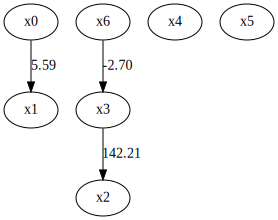

In [11]:
make_dot(model_lingam.adjacency_matrix_)

In [12]:
def apply_causality(df):
    df_apply_causal = pd.DataFrame(columns = df.columns)
    original = df.iloc[0]
    df_apply_causal.loc[0] = original
    for index, df_row in df.iloc[1:].iterrows():
        causal_ind = df_row.copy()
        for column in causal_order:
            value_diff = causal_ind[column] - original[column]
            if value_diff != 0:
                tmp_effects = df_causal_effects[df_causal_effects['from'] == column]
                for index, row in tmp_effects.iterrows():
#                     prob = rnd.random()
#                     if row['probability'] <= prob:
                    causal_ind[row['to']] = causal_ind[row['to']] + (value_diff * row['effect'])
        df_apply_causal.loc[len(df_apply_causal)] = causal_ind
    return df_apply_causal
    
def euclidean_distance(series1, series2):
    # Verificando se as séries têm o mesmo comprimento
    if len(series1) != len(series2):
        raise ValueError("As séries devem ter o mesmo comprimento.")
    
    # Calculando a diferença quadrática entre os elementos das séries
    squared_diff = (series1 - series2) ** 2
    
    # Calculando a soma das diferenças quadráticas
    sum_squared_diff = np.sum(squared_diff)
    
    # Calculando a raiz quadrada da soma
    euclidean_dist = np.sqrt(sum_squared_diff)
    
    return euclidean_dist

def get_contrafac_df_causal(solution_list_causal):
    lista_solution_causal = [[t.column for t in sublist] for sublist in solution_list_causal]

    # Inicializa uma lista para armazenar os resultados
    resultados = []

    # Loop sobre os valores na lista
    for lista_valores in lista_solution_causal:
        if len(lista_valores) > 1:
            for v1 in lista_valores:
                for v2 in lista_valores:
                    if v1 != v2:
                        # Cria uma condição para cada par de valores diferentes na lista
                        condicao = (df_causal_effects['to'].isin([v1, v2])) & (df_causal_effects['from'].isin([v1, v2]))
                        # Realiza a busca no DataFrame usando a condição e armazena os resultados
                        resultados.append(df_causal_effects[condicao])

    # Concatena os resultados em um único DataFrame
    if resultados:
        resultado_final = pd.concat(resultados)
        resultado_final = resultado_final.drop_duplicates()
    else:
        resultado_final = pd.DataFrame(columns = df_causal_effects.columns)
        
    return resultado_final

def analyse_contrafac(contrafac, df, original_ind):
    columns = [x.column for x in contrafac]
    condicao = (df['to'].isin(columns)) & (df['from'].isin(columns))
    ind = original_ind[columns]
    return [contrafac, df[condicao], ind]

def verificar_condicoes(row):
    if (row['from'] == 'mais' and row['to'] == 'mais' and row['effect'] > 0):
        return True
    elif row['from'] == 'menos' and row['to'] == 'menos' and row['effect'] > 0:
        return True
    elif row['from'] == 'mais' and row['to'] == 'menos' and row['effect'] < 0:
        return True
    elif row['from'] == 'menos' and row['to'] == 'mais' and row['effect'] < 0:
        return True
    else:
        return False

In [13]:
def get_causal_explain(X):
    original_ind = x_test.iloc[X].copy() #Original instance
    #self.ind_cur_class = ind_cur_class #Index in the shap corresponds to the original instance class
    explainerCSSE.current_class = p[X] #Original instance class
    explainerCSSE.original_ind = original_ind

    ind_cur_class = explainerCSSE.getBadClass()

    #Gets the valid values range of each feature
    features_range = []
    features_range = explainerCSSE.getFeaturesRange()

    #The DataFrame df will have the current population
    df = pd.DataFrame(columns=explainerCSSE.input_dataset.columns)

    #Generates the initial population with popinitial mutants        
    explainerCSSE.getPopInicial(df, features_range)
    df_causal = df.copy()
    dict_dfs = {}

    # for g in tqdm(range(explainerCSSE.num_gen), desc= "Processing..."):
    for g in tqdm(range(10), desc= "Processing..."):

        #To use on the parents of each generation
        parents = pd.DataFrame(columns=explainerCSSE.input_dataset.columns)

        #Copy parents to the next generation
        parents = df_causal.copy()
        dict_dfs[g] = {}

        parents_causal = apply_causality(parents)
        dict_dfs[g]['causal_parents'] = parents_causal
        #df will contain the new population
        df_causal = pd.DataFrame(columns=explainerCSSE.input_dataset.columns)
        evaluation_causal = []

        #Assessing generation counterfactuals
        explainerCSSE.fitness(dict_dfs[g]['causal_parents'], evaluation_causal, ind_cur_class)

        #The original individual will always be in the 0 position of the df - So that it is normalized too (it will be used later in the distance function)
        df_causal.loc[0] = original_ind.copy()

        #Copies to the next generation the per_elit best individuals
        explainerCSSE.elitism(evaluation_causal, df_causal, parents_causal)
        number_cross_repetitions = 0
        while len(df_causal) < explainerCSSE.pop_size + 1: #+1, as the 1st position is used to store the reference individual
            number_cross_repetitions_causal = explainerCSSE.crossover(df_causal, parents_causal, evaluation_causal, number_cross_repetitions)

            mutation_op = rnd.random()
            if mutation_op <= explainerCSSE.mutation_proba:
                explainerCSSE.mutation(df_causal, len(df_causal) - 1, features_range)


    evaluation = []
    evaluation_causal = []

    #Evaluating the latest generation
    explainerCSSE.fitness(df_causal, evaluation_causal, ind_cur_class)

    #Order the last generation by distance to the original instance     
    evaluation_causal.sort(key=lambda individual: individual.aval_norm) 

    #Getting the counterfactual CAUSAL set
    contrafactual_set_causal, solution_list_causal = explainerCSSE.getContrafactual(df_causal, evaluation_causal) 

    dict_dfs['contrafactual_set_causal'] = contrafactual_set_causal
    dict_dfs['solution_list_causal'] = solution_list_causal
    df_contrafac_causal = get_contrafac_df_causal(solution_list_causal)
    return [solution_list_causal, df_contrafac_causal, original_ind]

In [14]:
def run(original_row):
    response_list = get_causal_explain(original_row)
    list_analyse = []
    for contrafac_causal in response_list[0]:
        list_analyse.append(analyse_contrafac(contrafac_causal, response_list[1], response_list[2]))
    return list_analyse

In [15]:
%time
global_quant_changes = 0
global_quant_causal_changes = 0
global_quant_causal_rules = 0
global_quant_zeros_causal = 0
global_quant_full_causal = 0
global_quant_causal_contrafac = 0
global_quant_maioria_causal_satisfeita = 0
global_quant_contrafac_unico = 0

quant_original_instance = 20
for x in range(quant_original_instance):
    print(f"\nrun {x}")
    runs = run(x)
    for content in runs:
        controle = {}
        causal = content[0]
        df = content[1]
        ori = content[2]
        
        num_changes = len(causal)
        global_quant_changes += num_changes
        
        num_causal_rules = len(df)
        global_quant_causal_rules += num_causal_rules
        
        for attr in causal:
            key = attr.column
            if attr.value > ori[key]:
                controle[key] = 'mais'
            else:
                controle[key] = 'menos'

        df_temp = df.copy()
        df_temp['from'] = df['from'].map(controle)
        df_temp['to'] = df['to'].map(controle)
        df_temp['causal'] = df_temp.apply(verificar_condicoes, axis = 1)
        
        causal_finds = df_temp['causal'].sum()
        global_quant_causal_changes += causal_finds
        
        print(f'causal = \n{causal}\n')
        print(f'original = \n{ori}\n')
        print(f'df_temp = \n{display(df_temp)}\n')
        print('---------------------------------------------------\n')
        
        if len(df_temp) > 0:
            if causal_finds > 0:
                global_quant_causal_contrafac += 1
            else:
                print(f'nenhuma relaçao causal satisfeita')
                global_quant_zeros_causal += 1
                display(df_temp)
                print(f"original = {ori}")
                print(f"causal = {causal}")

            if causal_finds == num_causal_rules:
                global_quant_full_causal += 1
                if causal_finds > 2:
                    print(f'todas > 2 relaçoes causais satisfeitas')
                    display(df_temp)
                    print(f"original = {ori}")
                    print(f"causal = {causal}")
                elif causal_finds == 1:
                    print(f'todas = 1 relaçoes causais satisfeitas')
            
            if causal_finds >= (len(df_temp)/2):
                global_quant_maioria_causal_satisfeita += 1
        else:
#             if len(causal) > 0:
            global_quant_contrafac_unico += 1

                
quant_contrafac = quant_original_instance*K

print()
print(f"quantas instancias contrafactuais encontradas = {quant_contrafac}")
print(f"quantidade de mudanças totais = {global_quant_changes}")

print(f"quantas instancias tiveram pelo menos uma relação causal satisfeita = {global_quant_causal_contrafac}/{quant_contrafac}")

print(f"quantas relações causais foram encontradas = {global_quant_causal_rules}")

print(f"quantas relações causais foram satisfeitas = {global_quant_causal_changes}/{global_quant_causal_rules}")

print(f"quantas instâncias não tiveram nenhuma relação causal satisfeita = {global_quant_zeros_causal}/{quant_contrafac}")
print(f"quantas instâncias tiveram TODAS as relaçoes causais satisfeitas = {global_quant_full_causal}/{global_quant_causal_contrafac}")

print(f'quantas instancias causais teveram a maioria das relacoes causais satisfeitas = {global_quant_maioria_causal_satisfeita}/{quant_contrafac}')
print(f'quantas instancias tiveram um unico atributo modificado = {global_quant_contrafac_unico}/{quant_contrafac}')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 16.2 µs

run 0


Processing...: 100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


causal = 
[('Credit', 11750.87)]

original = 
Credit    1274.0
Name: 747, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 6987.648690638812), ('LoanDuration', 17.96676484358374)]

original = 
Credit          1274.0
LoanDuration      12.0
Name: 747, dtype: float64



,from,to,effect,causal
1,mais,mais,142.2142,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas
causal = 
[('Credit', 8657.612498182969), ('CheckingAccountBalance', 1.71)]

original = 
Credit                    1274.0
CheckingAccountBalance       1.0
Name: 747, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 27.46), ('CheckingAccountBalance', 1.78)]

original = 
Age                       37.0
CheckingAccountBalance     1.0
Name: 747, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 30.18), ('SavingsAccountBalance', 2.65)]

original = 
Age                      37.0
SavingsAccountBalance     1.0
Name: 747, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------


run 1


Processing...: 100%|██████████| 10/10 [00:31<00:00,  3.20s/it]

causal = 
[('Age', 39.58)]

original = 
Age    32.0
Name: 349, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 2672.6055025533096), ('LoanDuration', 4.788165992764418)]

original = 
Credit          1136.0
LoanDuration       9.0
Name: 349, dtype: float64



,from,to,effect,causal
1,menos,mais,142.2142,False


df_temp = 
None

---------------------------------------------------

nenhuma relaçao causal satisfeita


,from,to,effect,causal
1,menos,mais,142.2142,False


original = Credit          1136.0
LoanDuration       9.0
Name: 349, dtype: float64
causal = [('Credit', 2672.6055025533096), ('LoanDuration', 4.788165992764418)]
causal = 
[('LoanDuration', 6.89408299638221), ('SavingsAccountBalance', 2.77)]

original = 
LoanDuration             9.0
SavingsAccountBalance    3.0
Name: 349, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 38.76), ('CheckingAccountBalance', 1.98)]

original = 
Age                       32.0
CheckingAccountBalance     2.0
Name: 349, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 7391.72)]

original = 
Credit    1136.0
Name: 349, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 31.12), ('Credit', 4487.026659011868)]

original = 
Age         32.0
Credit    1136.0
Name: 349, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 626.2), ('CheckingAccountBalance', 1.39)]

original = 
Credit                    1136.0
CheckingAccountBalance       2.0
Name: 349, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------


run 2


Processing...: 100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


causal = 
[('Age', 44.55)]

original = 
Age    25.0
Name: 979, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 1816.9070201447457), ('LoanDuration', 16.943923387954882)]

original = 
Credit          1264.0
LoanDuration      15.0
Name: 979, dtype: float64



,from,to,effect,causal
1,mais,mais,142.2142,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas
causal = 
[('Credit', 2435.087785723248), ('SavingsAccountBalance', 2.58)]

original = 
Credit                   1264.0
SavingsAccountBalance       2.0
Name: 979, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 1601.8876234217894), ('CheckingAccountBalance', 2.69)]

original = 
Credit                    1264.0
CheckingAccountBalance       2.0
Name: 979, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 11.576812639780655), ('SavingsAccountBalance', 2.58)]

original = 
Age                      25.0
SavingsAccountBalance     2.0
Name: 979, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('SavingsAccountBalance', 2.1), ('HousingStatus', 2.74)]

original = 
SavingsAccountBalance    2.0
HousingStatus            2.0
Name: 979, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 1440.6230758795707), ('LoanDuration', 14.622014896786549), ('HousingStatus', 2.74)]

original = 
Credit           1264.0
LoanDuration       15.0
HousingStatus       2.0
Name: 979, dtype: float64



,from,to,effect,causal
1,menos,mais,142.214200,False
2,mais,menos,-2.699894,True


df_temp = 
None

---------------------------------------------------

causal = 
[('Sex', 0.52), ('Age', 14.26145011182453), ('Credit', 1048.980603277042)]

original = 
Sex          1.0
Age         25.0
Credit    1264.0
Name: 979, dtype: float64



,from,to,effect,causal
0,menos,menos,5.592995,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas

run 3


Processing...: 100%|██████████| 10/10 [00:29<00:00,  2.97s/it]


causal = 
[('Credit', 1100.1613688555444)]

original = 
Credit    697.0
Name: 925, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 32.929324002597205), ('Credit', 854.4249154578793), ('LoanDuration', 13.106956373696532)]

original = 
Age              46.0
Credit          697.0
LoanDuration     12.0
Name: 925, dtype: float64



,from,to,effect,causal
1,mais,mais,142.2142,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas

run 4


Processing...: 100%|██████████| 10/10 [00:31<00:00,  3.11s/it]

causal = 
[('Credit', 4343.251965349805)]

original = 
Credit    7253.0
Name: 411, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 25.56)]

original = 
Age    35.0
Name: 411, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 9019.92384407412), ('LoanDuration', 43.961567993190044), ('HousingStatus', 2.42)]

original = 
Credit           7253.0
LoanDuration       33.0
HousingStatus       3.0
Name: 411, dtype: float64



,from,to,effect,causal
1,mais,mais,142.214200,True
2,menos,mais,-2.699894,True


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 8203.394953377989), ('HousingStatus', 1.7)]

original = 
Credit           7253.0
HousingStatus       3.0
Name: 411, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 8203.394953377989), ('CheckingAccountBalance', 2.33), ('SavingsAccountBalance', 1.69)]

original = 
Credit                    7253.0
CheckingAccountBalance       1.0
SavingsAccountBalance        1.0
Name: 411, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------


run 5


Processing...: 100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


causal = 
[('Age', 48.54)]

original = 
Age    43.0
Name: 890, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 7372.29)]

original = 
Credit    2442.0
Name: 890, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 47.37), ('Credit', 3778.1919653498044)]

original = 
Age         43.0
Credit    2442.0
Name: 890, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 3382.709860662936), ('SavingsAccountBalance', 1.53)]

original = 
Credit                   2442.0
SavingsAccountBalance       1.0
Name: 890, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 47.37), ('SavingsAccountBalance', 1.53)]

original = 
Age                      43.0
SavingsAccountBalance     1.0
Name: 890, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 47.37), ('CheckingAccountBalance', 1.95)]

original = 
Age                       43.0
CheckingAccountBalance     1.0
Name: 890, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('CheckingAccountBalance', 2.77)]

original = 
CheckingAccountBalance    1.0
Name: 890, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------


run 6


Processing...: 100%|██████████| 10/10 [00:31<00:00,  3.14s/it]


causal = 
[('Age', 31.440700526657526)]

original = 
Age    32.0
Name: 646, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 4286.305557662548)]

original = 
Credit    4583.0
Name: 646, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 4478.287161879474), ('LoanDuration', 31.349946797190892)]

original = 
Credit          4583.0
LoanDuration      30.0
Name: 646, dtype: float64



,from,to,effect,causal
1,mais,menos,142.2142,False


df_temp = 
None

---------------------------------------------------

nenhuma relaçao causal satisfeita


,from,to,effect,causal
1,mais,menos,142.2142,False


original = Credit          4583.0
LoanDuration      30.0
Name: 646, dtype: float64
causal = [('Credit', 4478.287161879474), ('LoanDuration', 31.349946797190892)]
causal = 
[('CheckingAccountBalance', 1.52)]

original = 
CheckingAccountBalance    1.0
Name: 646, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------


run 7


Processing...: 100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


causal = 
[('Credit', 1045.368727168774)]

original = 
Credit    719.0
Name: 443, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 33.95), ('SavingsAccountBalance', 2.01)]

original = 
Age                      41.0
SavingsAccountBalance     1.0
Name: 443, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Sex', 0.14), ('Age', 5.090147175528435), ('CheckingAccountBalance', 1.52)]

original = 
Sex                        1.0
Age                       41.0
CheckingAccountBalance     1.0
Name: 443, dtype: float64



,from,to,effect,causal
0,menos,menos,5.592995,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas

run 8


Processing...: 100%|██████████| 10/10 [00:22<00:00,  2.28s/it]

causal = 
[('Credit', 4740.36)]

original = 
Credit    3965.0
Name: 76, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 29.459131375802603)]

original = 
Age    34.0
Name: 76, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 32.479348531851954), ('Credit', 3819.74)]

original = 
Age         34.0
Credit    3965.0
Name: 76, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('SavingsAccountBalance', 1.62)]

original = 
SavingsAccountBalance    1.0
Name: 76, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('CheckingAccountBalance', 2.59)]

original = 
CheckingAccountBalance    1.0
Name: 76, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------


run 9


Processing...: 100%|██████████| 10/10 [00:23<00:00,  2.36s/it]

causal = 
[('Credit', 3342.5300960243194)]

original = 
Credit    2613.0
Name: 225, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 3276.51), ('LoanDuration', 37.9439233879549)]

original = 
Credit          2613.0
LoanDuration      36.0
Name: 225, dtype: float64



,from,to,effect,causal
1,mais,mais,142.2142,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas
causal = 
[('SavingsAccountBalance', 1.75)]

original = 
SavingsAccountBalance    1.0
Name: 225, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 53.05)]

original = 
Age    27.0
Name: 225, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('CheckingAccountBalance', 2.83)]

original = 
CheckingAccountBalance    1.0
Name: 225, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------


run 10


Processing...: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]

causal = 
[('Credit', 12143.365625281738)]

original = 
Credit    1291.0
Name: 238, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 2041.7578125797545), ('LoanDuration', 16.75181272611194)]

original = 
Credit          1291.0
LoanDuration      12.0
Name: 238, dtype: float64



,from,to,effect,causal
1,mais,mais,142.2142,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas
causal = 
[('Credit', 926.53), ('SavingsAccountBalance', 1.64)]

original = 
Credit                   1291.0
SavingsAccountBalance       1.0
Name: 238, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('CheckingAccountBalance', 1.67)]

original = 
CheckingAccountBalance    1.0
Name: 238, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 1233.7005667470814), ('LoanDuration', 14.159914875505427), ('HousingStatus', 2.2)]

original = 
Credit           1291.0
LoanDuration       12.0
HousingStatus       3.0
Name: 238, dtype: float64



,from,to,effect,causal
1,mais,menos,142.214200,False
2,menos,mais,-2.699894,True


df_temp = 
None

---------------------------------------------------


run 11


Processing...: 100%|██████████| 10/10 [00:19<00:00,  2.00s/it]

causal = 
[('Credit', 5713.18)]

original = 
Credit    4241.0
Name: 597, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 3455.1364453883925), ('LoanDuration', 19.72)]

original = 
Credit          4241.0
LoanDuration      24.0
Name: 597, dtype: float64



,from,to,effect,causal
1,menos,menos,142.2142,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas
causal = 
[('CheckingAccountBalance', 1.41)]

original = 
CheckingAccountBalance    2.0
Name: 597, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('SavingsAccountBalance', 1.71)]

original = 
SavingsAccountBalance    1.0
Name: 597, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 64.97)]

original = 
Age    36.0
Name: 597, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 64.58), ('Credit', 4984.766648444731), ('LoanDuration', 26.429904234943606)]

original = 
Age               36.0
Credit          4241.0
LoanDuration      24.0
Name: 597, dtype: float64



,from,to,effect,causal
1,mais,mais,142.2142,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas

run 12


Processing...: 100%|██████████| 10/10 [00:20<00:00,  2.08s/it]

causal = 
[('LoanDuration', 26.22)]

original = 
LoanDuration    24.0
Name: 839, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 50.49)]

original = 
Age    46.0
Name: 839, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 8141.34)]

original = 
Credit    2611.0
Name: 839, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 3359.728256446011), ('LoanDuration', 25.75493083634816)]

original = 
Credit          2611.0
LoanDuration      24.0
Name: 839, dtype: float64



,from,to,effect,causal
1,mais,mais,142.2142,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas
causal = 
[('SavingsAccountBalance', 1.59)]

original = 
SavingsAccountBalance    1.0
Name: 839, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('CheckingAccountBalance', 1.71)]

original = 
CheckingAccountBalance    1.0
Name: 839, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------


run 13


Processing...: 100%|██████████| 10/10 [00:21<00:00,  2.12s/it]

causal = 
[('Credit', 1298.382001879766)]

original = 
Credit    1938.0
Name: 321, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 26.01)]

original = 
Age    32.0
Name: 321, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('CheckingAccountBalance', 1.54)]

original = 
CheckingAccountBalance    1.0
Name: 321, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 1590.4918327955243), ('LoanDuration', 30.155757395190466)]

original = 
Credit          1938.0
LoanDuration      24.0
Name: 321, dtype: float64



,from,to,effect,causal
1,mais,menos,142.2142,False


df_temp = 
None

---------------------------------------------------

nenhuma relaçao causal satisfeita


,from,to,effect,causal
1,mais,menos,142.2142,False


original = Credit          1938.0
LoanDuration      24.0
Name: 321, dtype: float64
causal = [('Credit', 1590.4918327955243), ('LoanDuration', 30.155757395190466)]

run 14


Processing...: 100%|██████████| 10/10 [00:20<00:00,  2.08s/it]

causal = 
[('Credit', 673.63)]

original = 
Credit    3621.0
Name: 949, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 1019.1968875904612), ('LoanDuration', 24.13499467971909)]

original = 
Credit          3621.0
LoanDuration      24.0
Name: 949, dtype: float64



,from,to,effect,causal
1,mais,menos,142.2142,False


df_temp = 
None

---------------------------------------------------

nenhuma relaçao causal satisfeita


,from,to,effect,causal
1,mais,menos,142.2142,False


original = Credit          3621.0
LoanDuration      24.0
Name: 949, dtype: float64
causal = [('Credit', 1019.1968875904612), ('LoanDuration', 24.13499467971909)]
causal = 
[('Sex', 0.37), ('Age', -4.2358668205757635), ('Credit', 4112.47290679533), ('CheckingAccountBalance', 1.66)]

original = 
Sex                          1.0
Age                         31.0
Credit                    3621.0
CheckingAccountBalance       1.0
Name: 949, dtype: float64



,from,to,effect,causal
0,menos,menos,5.592995,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas

run 15


Processing...: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]

causal = 
[('Credit', 4275.032598374026)]

original = 
Credit    2528.0
Name: 704, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 3910.2675503618666), ('LoanDuration', 27.97196169397744)]

original = 
Credit          2528.0
LoanDuration      27.0
Name: 704, dtype: float64



,from,to,effect,causal
1,mais,mais,142.2142,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas
causal = 
[('Age', 46.69)]

original = 
Age    32.0
Name: 704, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('CheckingAccountBalance', 2.51)]

original = 
CheckingAccountBalance    2.0
Name: 704, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('SavingsAccountBalance', 2.78)]

original = 
SavingsAccountBalance    1.0
Name: 704, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Sex', 0.12), ('Age', 34.013478104032906), ('Credit', 4155.9018071990195), ('CheckingAccountBalance', 1.8)]

original = 
Sex                          0.0
Age                         32.0
Credit                    2528.0
CheckingAccountBalance       2.0
Name: 704, dtype: float64



,from,to,effect,causal
0,mais,mais,5.592995,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas
causal = 
[('Credit', 3889.69869806279), ('LoanDuration', 27.269989359438178), ('CheckingAccountBalance', 2.34), ('HousingStatus', 2.95)]

original = 
Credit                    2528.0
LoanDuration                27.0
CheckingAccountBalance       2.0
HousingStatus                3.0
Name: 704, dtype: float64



,from,to,effect,causal
1,mais,mais,142.214200,True
2,menos,mais,-2.699894,True


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 1909.36822867284), ('SavingsAccountBalance', 2.77)]

original = 
Credit                   2528.0
SavingsAccountBalance       1.0
Name: 704, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------


run 16


Processing...: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]

causal = 
[('Credit', 9734.7)]

original = 
Credit    2246.0
Name: 589, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 5791.4000136059985), ('CheckingAccountBalance', 1.71)]

original = 
Credit                    2246.0
CheckingAccountBalance       1.0
Name: 589, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 6139.386933519258), ('LoanDuration', 21.962607363268784), ('SavingsAccountBalance', 1.18), ('HousingStatus', 2.23)]

original = 
Credit                   2246.0
LoanDuration               12.0
SavingsAccountBalance       1.0
HousingStatus               3.0
Name: 589, dtype: float64



,from,to,effect,causal
1,mais,mais,142.214200,True
2,menos,mais,-2.699894,True


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 7878.740267724606), ('LoanDuration', 22.097602042987873), ('HousingStatus', 1.13)]

original = 
Credit           2246.0
LoanDuration       12.0
HousingStatus       3.0
Name: 589, dtype: float64



,from,to,effect,causal
1,mais,mais,142.214200,True
2,menos,mais,-2.699894,True


df_temp = 
None

---------------------------------------------------

causal = 
[('Sex', 0.83), ('Credit', 3118.46), ('LoanDuration', 18.328811662055756), ('HousingStatus', 1.48)]

original = 
Sex                 1.0
Credit           2246.0
LoanDuration       12.0
HousingStatus       3.0
Name: 589, dtype: float64



,from,to,effect,causal
1,mais,mais,142.214200,True
2,menos,mais,-2.699894,True


df_temp = 
None

---------------------------------------------------


run 17


Processing...: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]

causal = 
[('Credit', 11468.883316987893)]

original = 
Credit    3872.0
Name: 779, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 34.83)]

original = 
Age    67.0
Name: 779, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Sex', 0.16), ('Age', 38.40951662939183)]

original = 
Sex     0.0
Age    67.0
Name: 779, dtype: float64



,from,to,effect,causal
0,mais,menos,5.592995,False


df_temp = 
None

---------------------------------------------------

nenhuma relaçao causal satisfeita


,from,to,effect,causal
0,mais,menos,5.592995,False


original = Sex     0.0
Age    67.0
Name: 779, dtype: float64
causal = [('Sex', 0.16), ('Age', 38.40951662939183)]
causal = 
[('Credit', 8662.60737711089), ('LoanDuration', 39.68014556288573), ('CheckingAccountBalance', 2.05), ('HousingStatus', 1.97)]

original = 
Credit                    3872.0
LoanDuration                18.0
CheckingAccountBalance       2.0
HousingStatus                3.0
Name: 779, dtype: float64



,from,to,effect,causal
1,mais,mais,142.214200,True
2,menos,mais,-2.699894,True


df_temp = 
None

---------------------------------------------------


run 18


Processing...: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]

causal = 
[('Credit', 1589.55)]

original = 
Credit    3441.0
Name: 618, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('CheckingAccountBalance', 2.62)]

original = 
CheckingAccountBalance    2.0
Name: 618, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 1973.5132084338509), ('CheckingAccountBalance', 2.6)]

original = 
Credit                    3441.0
CheckingAccountBalance       2.0
Name: 618, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Credit', 1952.887556284185), ('SavingsAccountBalance', 2.88)]

original = 
Credit                   3441.0
SavingsAccountBalance       2.0
Name: 618, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 24.06), ('Credit', 2936.68), ('SavingsAccountBalance', 2.54)]

original = 
Age                        21.0
Credit                   3441.0
SavingsAccountBalance       2.0
Name: 618, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------


run 19


Processing...: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]

causal = 
[('Credit', 6902.981973363126)]

original = 
Credit    674.0
Name: 188, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 33.23477057932328)]

original = 
Age    20.0
Name: 188, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('CheckingAccountBalance', 1.51)]

original = 
CheckingAccountBalance    1.0
Name: 188, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Age', 28.928164634586246), ('Credit', 827.17)]

original = 
Age        20.0
Credit    674.0
Name: 188, dtype: float64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('Sex', 0.89), ('Age', 28.312935213909526)]

original = 
Sex     1.0
Age    20.0
Name: 188, dtype: float64



,from,to,effect,causal
0,menos,mais,5.592995,False


df_temp = 
None

---------------------------------------------------

nenhuma relaçao causal satisfeita


,from,to,effect,causal
0,menos,mais,5.592995,False


original = Sex     1.0
Age    20.0
Name: 188, dtype: float64
causal = [('Sex', 0.89), ('Age', 28.312935213909526)]
causal = 
[('Credit', 1065.6424726025289), ('LoanDuration', 14.753891466269419), ('SavingsAccountBalance', 1.94), ('HousingStatus', 1.98)]

original = 
Credit                   674.0
LoanDuration              12.0
SavingsAccountBalance      2.0
HousingStatus              3.0
Name: 188, dtype: float64



,from,to,effect,causal
1,mais,mais,142.214200,True
2,menos,mais,-2.699894,True


df_temp = 
None

---------------------------------------------------


quantas instancias contrafactuais encontradas = 200
quantidade de mudanças totais = 181
quantas instancias tiveram pelo menos uma relação causal satisfeita = 22/200
quantas relações causais foram encontradas = 37
quantas relações causais foram satisfeitas = 29.0/37
quantas instâncias não tiveram nenhuma relação causal satisfeita = 6/200
quantas instâncias tiveram TODAS as relaçoes causais satisfeitas = 20/22
quantas instancias causais teveram a maioria das relacoes causais satisfeitas = 22/200
quantas instancias tiveram um unico atributo modificado = 75/200


In [140]:
len(runs[0][0])

1